# Macro Announcement Effects — Visualization & Diagnostics

This notebook explores the processed macro-announcement dataset and associated event study results to produce diagnostic plots and interactive visuals that complement the automated pipeline outputs.

## Workflow Overview

1. Load configuration, metadata, and pre-computed event study summaries.
2. Visualize cross-asset cumulative abnormal returns (CARs) and dispersion patterns.
3. Sample the aligned panel dataset to inspect behaviour across representative assets.
4. Build correlation, rolling relationship, and distribution plots for deeper diagnostics.

In [1]:
# Core imports
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

In [2]:
# Path configuration
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"

ALIGNED_DATA_PATH = PROCESSED_DIR / "aligned_data.csv"
METADATA_PATH = PROCESSED_DIR / "data_metadata.json"
EVENT_SUMMARY_PATH = RESULTS_DIR / "event_study_summary.csv"
EVENT_DETAILS_DIR = RESULTS_DIR / "tables" / "event_study"

print(f"Project root: {PROJECT_ROOT}")
print(f"Aligned data available: {ALIGNED_DATA_PATH.exists()}")
print(f"Event summary available: {EVENT_SUMMARY_PATH.exists()}")

Project root: D:\Works\Researchs\macro-announcement-effect
Aligned data available: True
Event summary available: True


In [3]:
# Load metadata for quick reference
with METADATA_PATH.open() as fh:
    metadata = json.load(fh)

variable_categories = metadata.get("variable_categories", {})
print("Rows, Columns:", metadata.get("data_shape"))
print("Variable groups:", list(variable_categories.keys())[:8], "...")
metadata.get("date_range", {})

Rows, Columns: [3650, 3451]
Variable groups: ['stock_prices', 'crypto_prices', 'economic_indicators', 'returns', 'volatilities', 'surprises'] ...


{'start': '2015-10-01 00:00:00',
 'end': '2025-09-27 00:00:00',
 'total_days': 3650}

In [4]:
# Helper utilities for sampling and reshaping
def get_category_columns(category: str, limit: int | None = 10) -> list[str]:
    columns = variable_categories.get(category, [])
    if limit is None:
        return columns
    return columns[:limit]


def load_aligned_data_subset(columns: list[str], n_rows: int = 5000) -> pd.DataFrame:
    if not ALIGNED_DATA_PATH.exists():
        raise FileNotFoundError(f"Missing processed dataset at {ALIGNED_DATA_PATH}")

    includes_date = "date" in columns
    requested_columns = [col for col in columns if col != "date"]

    available_columns = pd.read_csv(ALIGNED_DATA_PATH, nrows=0).columns.tolist()

    date_column_in_file: str | None = None
    if includes_date:
        for candidate in ("date", "Date", "DATE", "timestamp", "Timestamp", "Unnamed: 0", "index"):
            if candidate in available_columns:
                date_column_in_file = candidate
                break
        if date_column_in_file is None:
            raise KeyError(
                "Missing a date or index column in aligned data; searched for "
                "['date', 'Date', 'DATE', 'timestamp', 'Timestamp', 'Unnamed: 0', 'index']."
            )

    missing = [col for col in requested_columns if col not in available_columns]
    if missing:
        raise KeyError(f"Missing columns in aligned data: {missing}")

    read_columns = requested_columns.copy()
    if includes_date and date_column_in_file is not None:
        read_columns = [date_column_in_file] + read_columns

    df = pd.read_csv(ALIGNED_DATA_PATH, usecols=read_columns, nrows=n_rows)

    if includes_date and date_column_in_file is not None:
        df = df.rename(columns={date_column_in_file: "date"})
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.set_index("date").sort_index()

    return df


def augment_event_summary(df: pd.DataFrame) -> pd.DataFrame:
    expanded = df.copy()
    expanded["category"] = expanded.index.str.split("_", n=1).str[0]
    expanded["metric"] = expanded.index.str.split("_", n=1).str[1]
    return expanded

In [5]:
# Event study summary overview
event_summary = pd.read_csv(EVENT_SUMMARY_PATH, index_col=0)
display(event_summary.head())
event_summary_aug = augment_event_summary(event_summary)
display(event_summary_aug.head())

,mean_car,median_car,std_car,min_car,max_car,positive_events,negative_events,total_events
stocks_SP500_cumret_1d,-2.312965e-17,-4.163336e-17,4.936186e-17,-1.110223e-16,5.551115e-17,4.0,8.0,12.0
stocks_SP500_skewness_20d,-2.213472e-02,-5.955054e-02,8.501359e-02,-1.214271e-01,9.313831e-02,3.0,5.0,8.0
stocks_NASDAQ_cumret_1d,9.166391e-02,1.042361e-01,8.943026e-02,-8.860929e-03,1.670443e-01,3.0,1.0,4.0
stocks_RUSSELL2000_cumret_1d,-4.136376e-03,-1.252427e-02,1.474766e-01,-1.776271e-01,1.438601e-01,2.0,3.0,5.0
stocks_SPY_ETF_cumret_1d,-3.624895e-03,-6.917028e-03,5.012665e-02,-9.875796e-02,7.452107e-02,5.0,5.0,10.0


,mean_car,median_car,std_car,min_car,max_car,positive_events,negative_events,total_events,category,metric
stocks_SP500_cumret_1d,-2.312965e-17,-4.163336e-17,4.936186e-17,-1.110223e-16,5.551115e-17,4.0,8.0,12.0,stocks,SP500_cumret_1d
stocks_SP500_skewness_20d,-2.213472e-02,-5.955054e-02,8.501359e-02,-1.214271e-01,9.313831e-02,3.0,5.0,8.0,stocks,SP500_skewness_20d
stocks_NASDAQ_cumret_1d,9.166391e-02,1.042361e-01,8.943026e-02,-8.860929e-03,1.670443e-01,3.0,1.0,4.0,stocks,NASDAQ_cumret_1d
stocks_RUSSELL2000_cumret_1d,-4.136376e-03,-1.252427e-02,1.474766e-01,-1.776271e-01,1.438601e-01,2.0,3.0,5.0,stocks,RUSSELL2000_cumret_1d
stocks_SPY_ETF_cumret_1d,-3.624895e-03,-6.917028e-03,5.012665e-02,-9.875796e-02,7.452107e-02,5.0,5.0,10.0,stocks,SPY_ETF_cumret_1d


In [6]:
# Top positive and negative mean CAR contributions
top_n = 15
sorted_summary = event_summary.sort_values("mean_car", ascending=False)
top_positive = sorted_summary.head(top_n).assign(direction="positive")
top_negative = event_summary.sort_values("mean_car").head(top_n).assign(direction="negative")
combined = pd.concat([top_positive, top_negative])
combined = combined.reset_index().rename(columns={"index": "series"})

fig = px.bar(
    combined,
    x="mean_car",
    y="series",
    color="direction",
    orientation="h",
    text="mean_car",
    color_discrete_map={"positive": "#2ca02c", "negative": "#d62728"},
    title=f"Top ±{top_n} Mean CAR Effects"
)
fig.update_layout(yaxis_title="Series", xaxis_title="Mean CAR", legend_title="Direction")
fig.update_traces(texttemplate="%{x:.3f}", textposition="outside")
fig.show()

In [7]:
# Dispersion of CARs by standard deviation and frequency
scatter_df = event_summary_aug.reset_index().rename(columns={"index": "series"})
fig = px.scatter(
    scatter_df,
    x="std_car",
    y="mean_car",
    size="total_events",
    color="category",
    hover_data={"series": True, "median_car": ":.3f", "positive_events": True, "negative_events": True},
    title="Event Study Dispersion"
)
fig.update_layout(xaxis_title="Standard Deviation of CAR", yaxis_title="Mean CAR")
fig.show()

In [8]:
# Category-level summary statistics
category_summary = event_summary_aug.groupby("category")["mean_car"].agg(["mean", "median", "std", "count"]).sort_values("mean", ascending=False)
display(category_summary)
fig = px.box(
    event_summary_aug,
    x="category",
    y="mean_car",
    points="suspectedoutliers",
    title="Distribution of Mean CAR by Category"
)
fig.update_layout(xaxis_title="Category", yaxis_title="Mean CAR")
fig.show()

,mean,median,std,count
category,,,,
bear,0.050021,0.050021,NaN,1
crypto,0.033737,0.007467,0.099242,168
stocks,0.028930,0.024429,0.066706,200
trend,0.027070,0.027070,NaN,1
volatility,0.016150,0.011707,0.075458,51
fixed,0.009663,0.005557,0.065809,140
economic,0.007108,0.000000,0.026941,21
bull,0.000000,0.000000,NaN,1
high,0.000000,0.000000,NaN,1


In [9]:
# Sample representative series from the aligned panel
selected_series = [
    "stocks_SP500_cumret_1d",
    "stocks_VIX_cumret_10d",
    "crypto_Bitcoin_cumret_1d",
    "fixed_income_Treasury_10Y_Yield_cumret_1d",
]
aligned_sample = load_aligned_data_subset(["date"] + selected_series, n_rows=5000)
display(aligned_sample.head())
aligned_sample[selected_series].describe()

,stocks_SP500_cumret_1d,stocks_VIX_cumret_10d,crypto_Bitcoin_cumret_1d,fixed_income_Treasury_10Y_Yield_cumret_1d
date,,,,
2015-10-01,NaN,NaN,NaN,NaN
2015-10-02,0.014214,-0.074074,-0.001078,-0.026298
2015-10-03,0.000000,-0.074074,0.006038,0.000000
2015-10-04,0.000000,-0.074074,-0.001975,0.000000
2015-10-05,0.018125,-0.143271,0.008875,0.033130


,stocks_SP500_cumret_1d,stocks_VIX_cumret_10d,crypto_Bitcoin_cumret_1d,fixed_income_Treasury_10Y_Yield_cumret_1d
count,3649.000000,3649.000000,3649.000000,3649.000000
mean,0.000340,-0.000971,0.001681,0.000197
std,0.009530,0.183839,0.035626,0.025096
min,-0.127652,-0.929208,-0.464730,-0.347009
25%,-0.001399,-0.110053,-0.012171,-0.006511
50%,0.000000,-0.012443,0.001368,0.000000
75%,0.003080,0.087992,0.016183,0.007029
max,0.090895,1.214388,0.225119,0.404797


In [10]:
# Multi-series line chart for selected assets
line_df = aligned_sample.reset_index().rename(columns={"index": "date"})
fig = px.line(
    line_df,
    x="date",
    y=selected_series,
    title="Selected Series: Cumulative Returns Snapshot",
)
fig.update_layout(legend_title="Series", xaxis_title="Date", yaxis_title="Value")
fig.show()

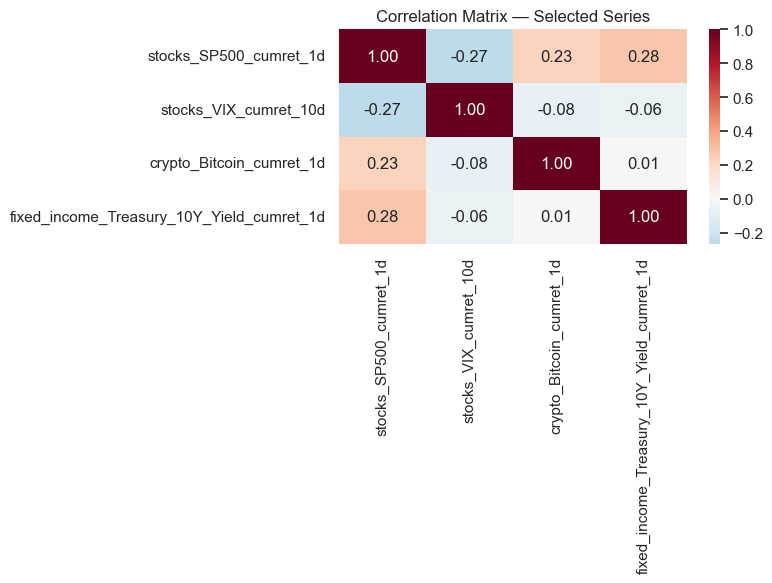

In [11]:
# Correlation matrix for the selected series
corr = aligned_sample[selected_series].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Correlation Matrix — Selected Series")
plt.tight_layout()
plt.show()

In [12]:
# Rolling correlation against SP500 benchmark
window = 90
anchor = "stocks_SP500_cumret_1d"
rolling_corr = pd.DataFrame({
    series: aligned_sample[anchor].rolling(window).corr(aligned_sample[series])
    for series in selected_series
    if series != anchor
})
rolling_corr.index = aligned_sample.index
fig = px.line(
    rolling_corr.reset_index().rename(columns={"index": "date"}),
    x="date",
    y=rolling_corr.columns,
    title=f"{window}-Day Rolling Correlation vs {anchor}",
)
fig.update_layout(yaxis_title="Correlation", xaxis_title="Date")
fig.show()

## Next Steps

- Swap `selected_series` for alternative groups (e.g., crypto volatility, macro indicators) to replicate the diagnostics.
- Export figures or tables by calling `fig.write_html(...)` / `fig.write_image(...)` if static artefacts are required.
- Integrate notebook outputs back into the reporting pipeline by checking data saved under `results/tables/`.